In [1]:
import heeps
import heeps.wavefront.qacits_vlt_package_v4 as qacits
from heeps.util.coord import disk_coord, mas2rms, rms2mas
from heeps.contrast.background import background
from photutils import CircularAperture, aperture_photometry
import numpy as np
import astropy.units as u
from astropy.io import fits
import os
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

mags = [ 5  6  7  8  9 10 11 12]
dits = [0.1 0.5 1.  2.  5. ]
calib drift = 110 points in each direction


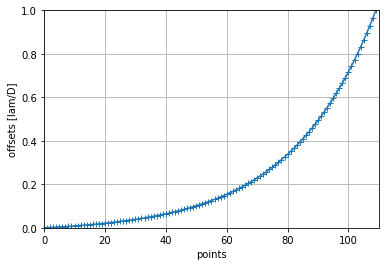

In [2]:
f_lyot_stop = 'ls_%s_%s_%s_%s_%s_%s.fits'
f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_%s_%s.fits'
f_point_err = 'wavefront/point/point_all_3600s_300ms_%s.fits'
cases = ['linear_drift_only', 'scao+linear_drift', 'scao+random_drift', 'scao_only']
targets = ['point', 'alphaCen', 'pi1Gru']
# define range of magnitudes
mag_min = 5
mag_max = 12
mags = np.arange(mag_min, mag_max+1)
print('mags = %s'%mags)
# define DITs (detector integration times)
dits = np.array([.1, .5, 1, 2, 5])
print('dits = %s'%dits)
# up to 0.1 lam/D, step = 1/100
# up to 1 lam/D, step = 1/10
#xy = np.append(np.arange(100)/1000, np.arange(1,11)/10)
#xy = np.arange(110)/109
logb = .02
xy = np.logspace(np.log10(logb), np.log10(1 + logb), 110) - logb
print('calib drift = %s points in each direction'%len(xy))
plt.plot(xy,'-+')
plt.xlim(0, len(xy))
plt.ylim(0, 1)
plt.xlabel('points')
plt.ylabel('offsets [lam/D]')
plt.grid(True), plt.grid(which='minor', linestyle=':');
# dictionary with default qacits parameters
default_params = dict(
    radii = {'inner': (0, 1.7), 'outer': (1.7, 2.3), 'full': (0, 2.7)},
    inner_slope = 1,#0.149,
    outer_slope = 1,#0.063,
    full_coeff = 1,#2,
    ratio = 0,
    phase_tolerance = 60,
    modul_tolerance = 0.33,
    small_tt_regime = 0.3,
    large_tt_regime = 0.2,
)
# qacits: number of averaged frames
n_bin           = 0 # if 0: no averaging, every estimates are returned in a 2D array
                    # if 1: average all frames before computing the estimate
                    # if n_bin=integer < n_img: will return as many estimates (frames are 
                    # averaged by bins of n_img/n_bin before computing the estimates).
force = 'outer'# None# 

In [3]:
rstar_catalog = {'alphaCen': 4.26, # mas
                 'pi1Gru': 9.18, # mas
                 }
def get_fp_offsets(target, diam_ext=36.905, nr=4, disp=True):
    if target in rstar_catalog:
        rstar = rstar_catalog[target]
        fp_offsets_mas = disk_coord(rstar, nr=nr)
        fp_offsets = mas2rms(fp_offsets_mas, diam_ext)
    else:
        fp_offsets = None
    # scatter plot
    if fp_offsets is not None and disp is True:
        print('noffsets = %s'%len(fp_offsets))
        plt.scatter(fp_offsets_mas[:,0], fp_offsets_mas[:,1])
        circ = plt.Circle((0,0), rstar, linestyle=':', color='k', fill=False)
        ax = plt.gca()
        ax.add_artist(circ)
        ax.axis('equal')
        plt.xlabel('x [mas]')
        plt.ylabel('y [mas]')
        plt.title('R = %s mas (%s) - %s pts'%(rstar, target, len(fp_offsets)))
    return fp_offsets

def get_lamD(conf): # in mas per lambda/D
    diamLS = conf['diam_ext'] - conf['diam_nominal']*conf['ls_dRext']
    lamD = conf['lam']/diamLS*u.rad.to('mas')
    return lamD

def get_fwhm(conf): # in pixels
    fwhm = get_lamD(conf)/conf['pscale']
    return fwhm

def get_psf_flux(conf, psf, verbose=False): # photutils aperture photometry
    fwhm = get_fwhm(conf) 
    nimg = psf.shape[-1]
    aper = CircularAperture((nimg//2, nimg//2), r=fwhm/2)
    psf_flux = aperture_photometry(psf, aper)['aperture_sum'].data
    if verbose is True:
        print('photutils aperture photometry: psf_flux=%s'%np.round(psf_flux,5))
    return psf_flux

def create_psfs(band, mode, ls_params, case='calib', pupil_shape='', target='', 
        verbose=False):
    # initialize conf
    dir_output = os.path.join('qacits_%s/%s_%s'%(pupil_shape, band, mode), 
            target, case)
    conf = dict(dir_output=dir_output, band=band, mode=mode, nframes=2*len(xy),
            add_phase=True, add_point_err=True)
    if pupil_shape == 'circ':
        conf.update(f_pupil='', spi_width=0, seg_width=0, seg_gap=0)
    else:
        conf.update(f_pupil='pupil/ELT_fullM1.fits')
    conf = heeps.config.read_config(verbose=False, **conf)
    conf = heeps.config.update_config(saveconf=True, verbose=verbose, **conf)
    conf['f_phase'] = os.path.join(conf['dir_input'], 
            f_phase%(band, conf['npupil']))
    conf['f_point_err'] = os.path.join(conf['dir_input'], f_point_err%band)
    conf['f_lyot_stop'] = os.path.join(conf['dir_input'], 'pupil', pupil_shape, 
            f_lyot_stop%(band, mode, *ls_params, conf['npupil']))
    conf['ls_dRext'] = ls_params[0]
    conf['fp_offsets'] = get_fp_offsets(target)
    # load errors
    phase_screens, amp_screens, tiptilts, misaligns \
            = heeps.wavefront.load_errors(verbose=verbose, **conf)
    # linear tiptilt
    lamD = get_lamD(conf)
    xy_rms = mas2rms(xy*lamD, conf['diam_ext']) # converted to mas, then to rms
    tt = np.array([(x,0) for x in xy_rms] + [(0,y) for y in xy_rms])
    # choose case
    print('\nCase = %s'%case)
    if 'scao_only' in case:
        tiptilts = np.array([None]*conf['nframes'])
    elif 'scao+linear_drift' in case:
        tiptilts = tt
    elif 'scao+random_drift' in case:
        pass
    else: # calib = linear drift only
        tiptilts = tt
        phase_screens = np.array([None]*conf['nframes'])
    # load PSFs
    try:
        psf = fits.getdata(os.path.join(conf['dir_output'], 
            'offaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        psfs = fits.getdata(os.path.join(conf['dir_output'], 
            'onaxis_PSF_%s_%s.fits'%(conf['band'], conf['mode'])))
        print('Loading "%s"'%dir_output)
    except FileNotFoundError:
        print('Simulating "%s"'%dir_output)
        # initialize wavefront
        wf = heeps.pupil.pupil(savefits=True, verbose=verbose, **conf)
        # off-axis PSF
        psf = heeps.wavefront.propagate_one(wf, onaxis=False, savefits=True, 
                verbose=verbose, **conf)
        # on-axis PSFs
        psfs = heeps.wavefront.propagate_cube(wf, phase_screens=phase_screens,
                amp_screens=amp_screens, tiptilts=tiptilts, misaligns=misaligns, 
                onaxis=True, savefits=True, verbose=True, **conf)
    # tiptilts in lam/D
    tt_xy = rms2mas(tiptilts, conf['diam_ext'])/lamD # converted to mas, then to lam/D
    tt_lamD = np.sqrt(tt_xy[:,0]**2 + tt_xy[:,1]**2)
    return conf, psf, psfs, tt_lamD

def point_err_rms(qacits_params, img_cube, psf_flux, fwhm, tt_lamD, 
        model_calibration=False, verbose=True):
    # bin + normalize on-axis PSF cube
    img_cube = qacits.bin_images(img_cube, n_bin)
    #img_cube /= psf_flux
    nimg = img_cube.shape[-1]
    # tip-tilt estimate
    tiptilt_estimate = qacits.quadrant_tiptilt_v8(qacits_params, img_cube, 
        (nimg//2, nimg//2), psf_flux, fwhm, calib_tt=tt_lamD, 
        model_calibration=model_calibration, force=force, exact=True, 
        verbose=verbose)
    # RMS error
    lamD = get_lamD(conf)
    tt_real = tt_lamD*lamD
    tt_est = np.sqrt(tiptilt_estimate[:,0]**2 + tiptilt_estimate[:,1]**2)*lamD
    rms = np.sqrt(np.mean((tt_real - tt_est)**2))
    return tt_real, tt_est, rms

def plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=None, nframes=None):
    # if no qacits_params provided --> calibrate with default params
    if qacits_params == None:
        model_calibration = True
        qacits_params = deepcopy(default_params)
    else:
        model_calibration = False
    # QACITS tip-tilt estimate
    psf_flux = get_psf_flux(conf, psf)
    fwhm = get_fwhm(conf)
    tt_real, tt_est, rms = point_err_rms(qacits_params, psfs[:nframes], psf_flux,
        fwhm, tt_lamD[:nframes], model_calibration=model_calibration)
    print('rms = %s mas'%round(rms, 3))
    ts = conf['dit']*np.arange(len(tt_lamD))[:nframes]
    fig, (a0, a1) = plt.subplots(2, 1, figsize=(10,6), sharex=True)
    fig.subplots_adjust(hspace=0)
    a0.plot(ts, tt_real, label='error signal', color='k', linestyle='--')
    a0.plot(ts, tt_est[:nframes], label='QACITS estimate')
    a0.set_title('correction at %s band'%conf['band'])
    a0.set_ylabel('Pointing error (mas)')
    a0.legend(loc='upper right'); a0.grid(True)
    a0.set_xlim((0, ts[-1]))
    a0.set_ylim(bottom=0)
    error = abs(tt_real - tt_est)
    a1.plot(ts, error[:nframes], label='$\mu = %3.2f mas, \sigma = %3.2f mas$'\
                %(np.mean(error), np.std(error)))
    a1.set_xlabel('Duration (s)')
    a1.set_ylabel('Residuals (mas)')
    a1.legend(loc='upper right'); a1.grid(True)
    a1.set_xlim((0, ts[-1]))
    a1.set_ylim(bottom=0)
    return qacits_params

def rms_mag(qacits_params, conf, psf, psfs, tt_lamD, nframes=None):
    fwhm = get_fwhm(conf)
    rms_arr = np.empty((len(dits), len(mags)))
    for i, conf['dit'] in enumerate(dits):
        if i == 0:
            print('DIT = %s s'%conf['dit'], end='')
        else:
            print(', %s s'%conf['dit'], end='')
        for j, conf['mag'] in enumerate(mags):
            psf_ON, psf_OFF = background(deepcopy(psfs), deepcopy(psf), **conf)
            psf_flux = get_psf_flux(conf, psf_OFF)
            _, _, rms = point_err_rms(qacits_params, psf_ON[:nframes],
            psf_flux, fwhm, tt_lamD[:nframes], model_calibration=False)
            rms_arr[i,j] = rms
    return rms_arr

def plot_rms_mag(rms_arr):
    plt.figure(figsize=(9, 5))
    for dit, rms in zip(dits, rms_arr):
        plt.plot(mags, rms, label='DIT = %s s'%dit)
    plt.legend()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.yscale('log')
    plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))    
    plt.xlim(min(mags), max(mags))
    plt.ylim(1e-1, 1e2)
    plt.xlabel('Star mag')
    plt.ylabel('Pointing error (mas rms)')


# 1) Circular pupil (L-band CVC)
### Calibration: x,y pointing drift -> 1 lambda/D


Case = calib
Loading "qacits_circ/L_CVC/calib"

Model calibration results:
Inner slope = 0.390
Outer slope = 0.178
Full coeff  = 3.017
rms = 1.906 mas


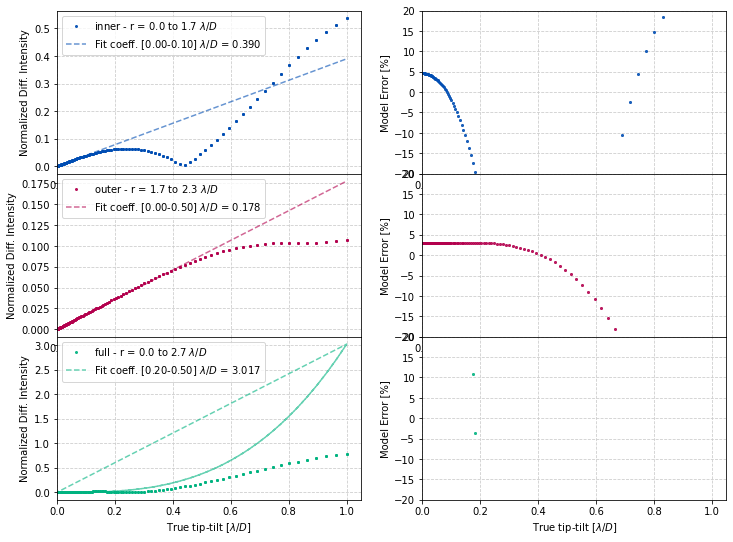

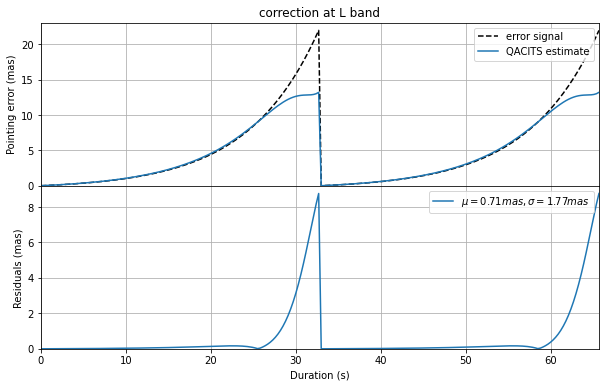

In [4]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317], pupil_shape='circ')
plot_point_err(conf, psf, psfs, tt_lamD);

# 2) Full M1 pupil
## 2.1) L-band CVC
### Calibration: x,y pointing drift -> 1 lambda/D


Case = calib
Loading "qacits_/L_CVC/calib"

Model calibration results:
Inner slope = 0.234
Outer slope = 0.128
Full coeff  = 4.319
rms = 0.68 mas


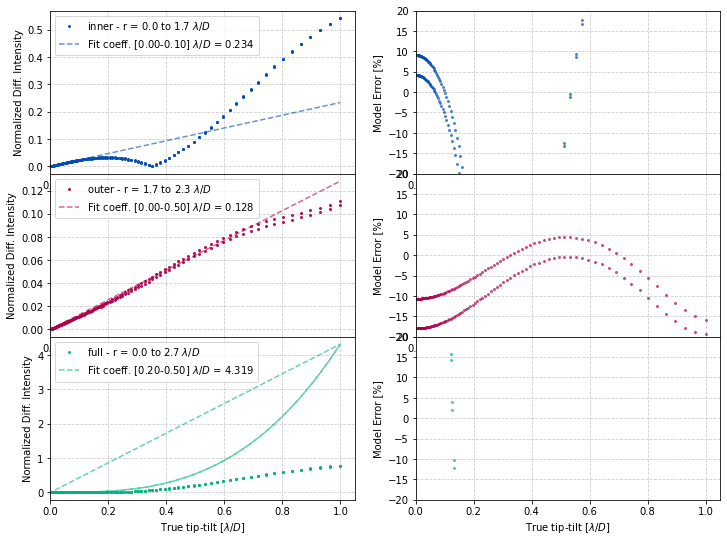

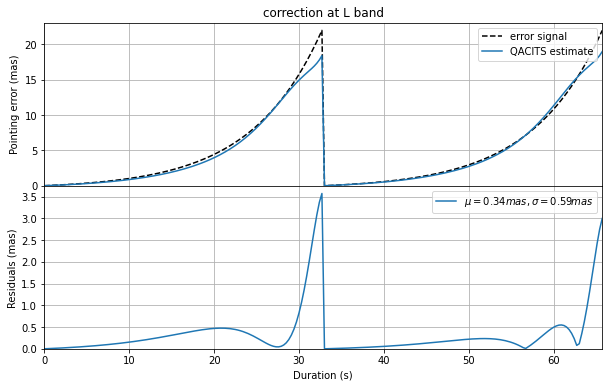

In [5]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317])
L_CVC_params = plot_point_err(conf, psf, psfs, tt_lamD)

### SCAO + random pointing drift (quasistatics = 0.4 mas rms ; jitter = 2 mas rms)


Case = scao+random_drift
Loading "qacits_/L_CVC/scao+random_drift"
rms = 0.337 mas


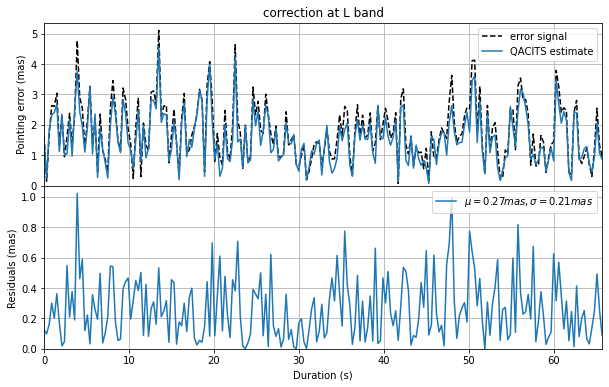

In [6]:
conf, psf, psfs, tt_lamD = create_psfs('L', 'CVC', [0.0291, 0.08, 0.0317], 'scao+random_drift')
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=L_CVC_params);

DIT = 0.1 s, 0.5 s, 1.0 s, 2.0 s, 5.0 s

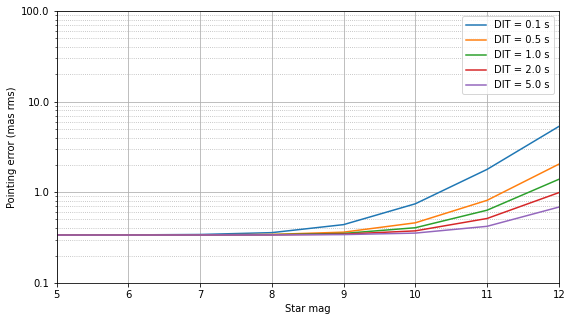

In [7]:
rms_arr = rms_mag(L_CVC_params, conf, psf, psfs, tt_lamD)
plot_rms_mag(rms_arr)

## 2.2) N-band CVC
### Calibration: x,y pointing drift -> lambda/D


Case = calib
Loading "qacits_/N2_CVC/calib"

Model calibration results:
Inner slope = 0.223
Outer slope = 0.133
Full coeff  = 3.024
rms = 3.782 mas


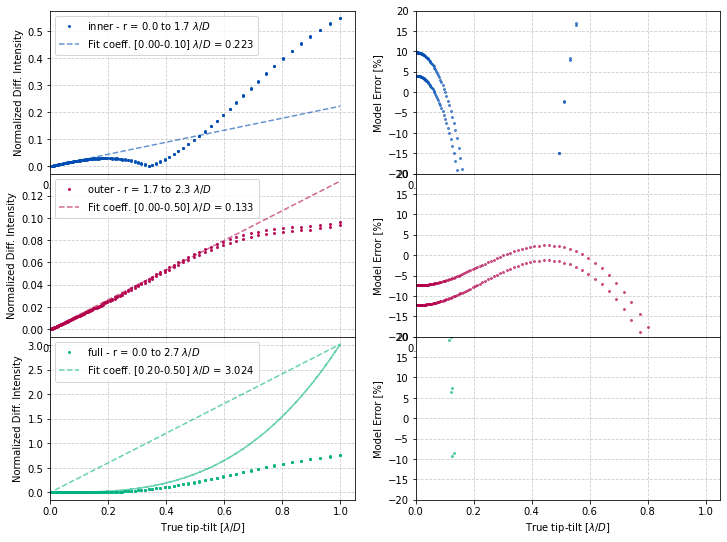

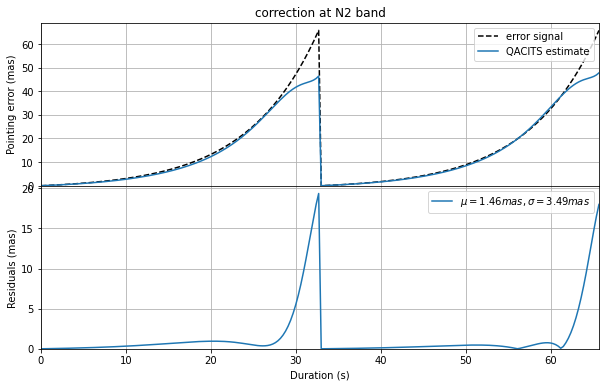

In [8]:
conf, psf, psfs, tt_lamD = create_psfs('N2', 'CVC', [0.0356, 0.08, 0.0383])
N_CVC_params = plot_point_err(conf, psf, psfs, tt_lamD)

### SCAO + random pointing drift (3 times L-band)


Case = scao+random_drift
Loading "qacits_/N2_CVC/scao+random_drift"
rms = 0.521 mas


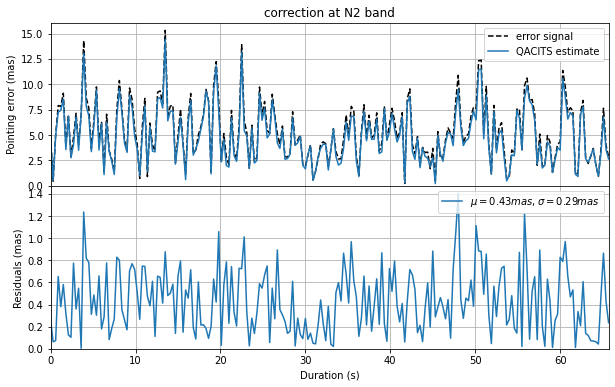

In [9]:
conf, psf, psfs, tt_lamD = create_psfs('N2', 'CVC', [0.0356, 0.08, 0.0383], 'scao+random_drift')
plot_point_err(conf, psf, psfs, tt_lamD, qacits_params=N_CVC_params);

DIT = 0.1 s, 0.5 s, 1.0 s, 2.0 s, 5.0 s

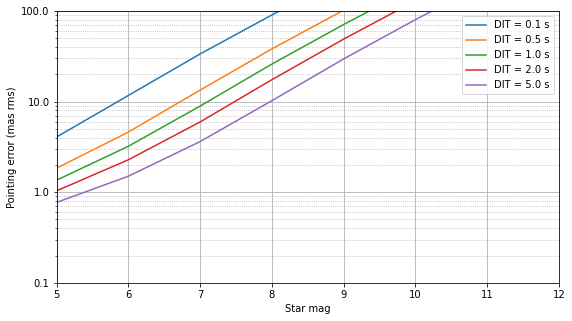

In [10]:
rms_arr = rms_mag(N_CVC_params, conf, psf, psfs, tt_lamD)
plot_rms_mag(rms_arr)